# 1.

In [10]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import random

쿠다 : (Computed Unified Device Architecture)는 NVIDIA에서 개발한 GPU 개발 툴

많은 양의 연산을 동시 처리하는 것이 목표. 딥러닝, 채굴(빝코인) 등등 연산에 많이 쓰인다고 한다.

source : https://kaen2891.tistory.com/20


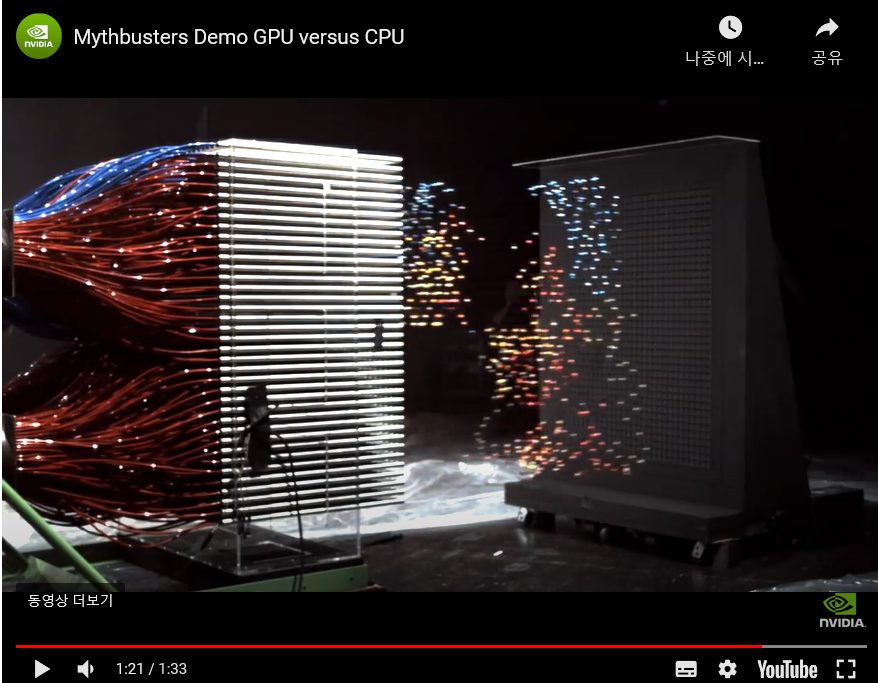

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(2020)
if device == 'cuda':
    torch.cuda.manual_seed_all(2020)

## hyperparameter 고정. 여기서는 주관이 개입된 것으로 보인다.

In [12]:
learning_rate = 0.1
training_epochs = 15 # 한 번의 fw,bw pass를 full로 거침. 한 번 학습 완료한 것.
# epoch은 overfitting과 비례
batch_size = 100 #한 batch 당 training example size

이런 식의 hyper parameter들이 사실 중요한 상황에서 ML에서는 grid search를 보통 하는데

Gradient boosting regressor에서의 예시는 이런 식이다

source : https://medium.com/@cjl2fv/an-intro-to-hyper-parameter-optimization-using-grid-search-and-random-search-d73b9834ca0a

--------------------------------------------------------------------------------------
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

num_estimators = [500,1000]
learn_rates = [0.02, 0.05]
max_depths = [1, 2]
min_samples_leaf = [5,10]
min_samples_split = [5,10]

param_grid = {'num_estimators': num_estimators,
              'learning_rate': learn_rates,
              'max_depth': max_depths,
              'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split}

grid_search = GridSearchCV(GradientBoostingRegressor(loss='huber'),
                           param_grid, cv=3, return_train_score=True)
grid_search.fit(x_train, y_train)

----------------------------------------------------------------------------------



## import data , tensor로 변환

In [13]:
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [14]:
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True, #batch를 무작위로 불러와?
                                          drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False, 
                                          drop_last=True) #K fold CV랑 유사한 상황에서 잔여 자료를 버릴까?

In [15]:
class CNN(torch.nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        
        # Essentially, it means that each connection between layers (in this case between the last densely connected layer and the readout layer) will only be used with probability 0.5 when training.
        # overfitting 방지 위함
        
        # source : 
        # https://stackoverflow.com/questions/35545798/keep-prob-in-tensorflow-mnist-tutorial

        
    
        
        # 1st layer 28^2,100
        self.layer1 = torch.nn.Sequential(
        torch.nn.Linear(784, 100, bias = True),
        torch.nn.BatchNorm1d(100),
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.3))
        
        # 2nd layer 100,100
        self.layer2 = torch.nn.Sequential(
        torch.nn.Linear(100, 100, bias = True),
        torch.nn.BatchNorm1d(100), 
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.3))
        
        # 3rd layer 100,10
        self.layer3 = torch.nn.Linear(100, 10, bias = True)
        torch.nn.init.xavier_uniform_(self.layer3.weight)

# 3 layers
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [16]:
model = CNN().to(device)

In [17]:
# Loss Function & Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
train_total_batch = len(train_loader)

In [31]:
train_total_batch # 이 600이 어찌 나왔는지 급하게 하느라 살펴보지는 못했습ㄴ디ㅏ

600

밑에 코드는 매우 느린 속도를 자랑한다.

In [19]:
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in train_loader:
        X = X.view(-1, 28*28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad() # gradient 누적방지위해 0으로 할 때마다 초기화
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)  # criterion이 crossentropyloss라고 바로 위에서 정의해놓았음.
        cost.backward()
        optimizer.step()

        avg_cost += cost / train_total_batch # 계속 누적된다.

        avg_cost += cost / train_total_batch

    print('[Epoch: {:>4}] cost = {:>.4}'.format(epoch + 1, avg_cost))

print('Done')

[Epoch:    1] cost = 0.5035
[Epoch:    2] cost = 0.3705
[Epoch:    3] cost = 0.3376
[Epoch:    4] cost = 0.3184
[Epoch:    5] cost = 0.3051
[Epoch:    6] cost = 0.3005
[Epoch:    7] cost = 0.291
[Epoch:    8] cost = 0.2812
[Epoch:    9] cost = 0.2732
[Epoch:   10] cost = 0.2734
[Epoch:   11] cost = 0.2661
[Epoch:   12] cost = 0.2722
[Epoch:   13] cost = 0.2608
[Epoch:   14] cost = 0.2519
[Epoch:   15] cost = 0.2574
Done


In [20]:
with torch.no_grad():
    model.eval()    # set the model to evaluation mode (dropout=False)

    # Test the model using test sets
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

C:\Users\drlim\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\drlim\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.9266999959945679
Label:  7
Prediction:  7


# 2. 이 문제가 원하는 것은 layer의 수는 그대로, 각 layer에 있는 node의 숫자의 증감에 따른 성능을 비교하는 것이다

## 증 : 200,200

In [21]:
class CNN(torch.nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        
        # 1st layer (784, 200)
        self.layer1 = torch.nn.Sequential(
        torch.nn.Linear(784, 200, bias = True),
        torch.nn.BatchNorm1d(200),
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.3))
        
        # 2nd layer (200, 200)
        self.layer2 = torch.nn.Sequential(
        torch.nn.Linear(200, 200, bias = True),
        torch.nn.BatchNorm1d(200), 
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.3))
        
        # 3rd layer (200, 10)
        self.layer3 = torch.nn.Linear(200, 10, bias = True)
        torch.nn.init.xavier_uniform_(self.layer3.weight)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [22]:
model = CNN().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
train_total_batch = len(train_loader)

당연히 더 느린 속도를 자랑한다.

In [24]:
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in train_loader:
        X = X.view(-1, 28*28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / train_total_batch

    print('[Epoch: {:>4}] cost = {:>.4}'.format(epoch + 1, avg_cost))

print('Done')

[Epoch:    1] cost = 0.4707
[Epoch:    2] cost = 0.333
[Epoch:    3] cost = 0.298
[Epoch:    4] cost = 0.2801
[Epoch:    5] cost = 0.2641
[Epoch:    6] cost = 0.2571
[Epoch:    7] cost = 0.247
[Epoch:    8] cost = 0.2499
[Epoch:    9] cost = 0.2396
[Epoch:   10] cost = 0.2212
[Epoch:   11] cost = 0.217
[Epoch:   12] cost = 0.2149
[Epoch:   13] cost = 0.2153
[Epoch:   14] cost = 0.2197
[Epoch:   15] cost = 0.2101
Done


In [25]:
with torch.no_grad():
    model.eval()    # set the model to evaluation mode (dropout=False)

    # Test the model using test sets
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

Accuracy: 0.9266999959945679
Label:  2
Prediction:  2


## 감 : 50,50

In [26]:
class CNN(torch.nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        
        # 1st layer (784, 50)
        self.layer1 = torch.nn.Sequential(
        torch.nn.Linear(784, 50, bias = True),
        torch.nn.BatchNorm1d(50),
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.3))
        
        # 2nd layer (50, 50)
        self.layer2 = torch.nn.Sequential(
        torch.nn.Linear(50, 50, bias = True),
        torch.nn.BatchNorm1d(50), 
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.3))
        
        # 3rd layer (50, 10)
        self.layer3 = torch.nn.Linear(50, 10, bias = True)
        torch.nn.init.xavier_uniform_(self.layer3.weight)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [27]:
model = CNN().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)                 

꽤나 빠르다.
system time을 계산해서 
system time이 layer의 - 에 비례한다
이러한 관계를 확립하면 좋을 것 같다.

In [28]:
train_total_batch = len(train_loader)

for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in train_loader:
        X = X.view(-1, 28*28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad() # gradient 누적방지위해 0으로 할 때마다 초기화
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)  # criterion이 crossentropyloss라고 바로 위에서 정의해놓았음.
        cost.backward()
        optimizer.step()

        avg_cost += cost / train_total_batch # 계속 누적된다.

    print('[Epoch: {:>4}] cost = {:>.4}'.format(epoch + 1, avg_cost))

print('Done')

[Epoch:    1] cost = 0.6301
[Epoch:    2] cost = 0.4757
[Epoch:    3] cost = 0.4455
[Epoch:    4] cost = 0.4217
[Epoch:    5] cost = 0.4165
[Epoch:    6] cost = 0.4085
[Epoch:    7] cost = 0.4024
[Epoch:    8] cost = 0.3925
[Epoch:    9] cost = 0.3854
[Epoch:   10] cost = 0.3936
[Epoch:   11] cost = 0.3745
[Epoch:   12] cost = 0.3736
[Epoch:   13] cost = 0.3564
[Epoch:   14] cost = 0.3688
[Epoch:   15] cost = 0.3637
Done


In [29]:

with torch.no_grad():
    model.eval()    # set the model to evaluation mode (dropout=False)

    # Test the model using test sets
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test  # 이산적.내가 이산적이라고 한 의미는 밑에 써놓았다.
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item()) # 이거는 전체 data에서의 평균 개념

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item()) # 한 item에 대한 softmax classification에서 가장 해당 확률값이 큰 class는 뭐?

Accuracy: 0.9387000203132629
Label:  3
Prediction:  3


Cost가 확연히 더 높으면서 Accuracy가 0.1%p 더 높은 부자연스러운 현상의 발생.

Cost는 한 data에서 예측한 다항 확률값들과 real target의 차이 -> 전체 데이터로 평균한 연속적인 개념.

Accuracy는 data point 각각에서 맞으면 1, 틀리면 0인 이산적인 개념.

이 차이 때문에 내가 실행한 예시에서는 layer size가 작은 경우에서 **결국에** 맞은 경우는 더욱 많으나 **과정은** 전자가 더욱 좋았나보다.



